<a href="https://colab.research.google.com/github/ErikSeras/usos_r_python/blob/main/analisis_espacial/001_densidad_poblacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hacer un mapa de densidad poblacional de Nepal con Geopandas

Elaborado por: __Erik Seras__

# 1 Instalaciones previas

## 1.1 Instalación de archivos de linux para análisis espacial.

Presionar la tecla `Enter` luego de hacer clic en el campo que sale al ejecutar la siguiente celda para que se pueda instalar.

In [ ]:
! sudo add-apt-repository ppa:ubuntugis/ubuntugis-unstable
! sudo apt-get update
! sudo apt-get install libudunits2-dev libgdal-dev libgeos-dev libproj-dev
! sudo apt-get install libprotobuf-dev protobuf-compiler libv8-dev libjq-dev

## 1.2 Instalación de geopandas

In [ ]:
! pip install geopandas

# 2 Elaboración del mapa de densidad poblacional

Tutoriales que ayudaron a desarrollar este ejercicio:
- https://www.youtube.com/watch?v=Qc-EPKucq0w
- https://www.youtube.com/watch?v=Ws968wOdgAA

Estadísticas de población de Nepal: https://www.citypopulation.de/php/nepal-mun-admin.php

Data DIVA-GIS (obtención de shapefiles en formato zip): https://www.diva-gis.org/gdata

## 2.1 Librerías necesarias

In [75]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

## 2.2 Lectura de la data

In [4]:
# Leer la data directamente de un link de internet
data = pd.read_html(io = 'https://www.citypopulation.de/php/nepal-mun-admin.php')

In [5]:
# Obtener la data en un dataframe
for population_data in data:
    print(population_data)

                    Name         Native  ... PopulationCensus2011-06-22 Unnamed: 5
0         Achām [Achham]           अछाम  ...                     257477          →
1    Bannigadhi Jayagadh  बान्नीगडीजैगड  ...                      17426          →
2              Chaurpati        चौरपाटी  ...                      25215          →
3                Dhakari          धकारी  ...                      21570          →
4             Kamalbazar        कमलबजार  ...                      23770          →
..                   ...            ...  ...                        ...        ...
846             Sunkoshi        सुनकोशी  ...                      11992          →
847                Tapli         ताप्ली  ...                      14567          →
848              Triyuga       त्रियुगा  ...                      88967          →
849        Udayapurgadhi      उदयपुरगढी  ...                      30780          →
850        Nepāl [Nepal]          नेपाल  ...                   26494504        NaN

[85

In [6]:
population_data.head()

,Name,Native,Status,PopulationCensus2001-05-28,PopulationCensus2011-06-22,Unnamed: 5
0,Achām [Achham],अछाम,District,231285,257477,→
1,Bannigadhi Jayagadh,बान्नीगडीजैगड,Rural Municipality,17102,17426,→
2,Chaurpati,चौरपाटी,Rural Municipality,23323,25215,→
3,Dhakari,धकारी,Rural Municipality,...,21570,→
4,Kamalbazar,कमलबजार,Municipality,...,23770,→


## 2.3 Guardar la data en excel

In [7]:
population_data.to_excel(r'pop.xlsx')

## 2.4 Leer los datos del excel

In [8]:
population_data = pd.read_excel(r'pop.xlsx')

In [9]:
population_data.head()

,Unnamed: 0,Name,Native,Status,PopulationCensus2001-05-28,PopulationCensus2011-06-22,Unnamed: 5
0,0,Achām [Achham],अछाम,District,231285,257477,→
1,1,Bannigadhi Jayagadh,बान्नीगडीजैगड,Rural Municipality,17102,17426,→
2,2,Chaurpati,चौरपाटी,Rural Municipality,23323,25215,→
3,3,Dhakari,धकारी,Rural Municipality,...,21570,→
4,4,Kamalbazar,कमलबजार,Municipality,...,23770,→


Columnas del data frame

In [10]:
population_data.columns

Index(['Unnamed: 0', 'Name', 'Native', 'Status', 'PopulationCensus2001-05-28',
       'PopulationCensus2011-06-22', 'Unnamed: 5'],
      dtype='object')

## 2.5 Procesar la data

Solo se requieren 3 columnas para el ejemplo.

In [11]:
population_data = population_data[['Name', 'Status', 'PopulationCensus2011-06-22']]

In [12]:
population_data.head()

,Name,Status,PopulationCensus2011-06-22
0,Achām [Achham],District,257477
1,Bannigadhi Jayagadh,Rural Municipality,17426
2,Chaurpati,Rural Municipality,25215
3,Dhakari,Rural Municipality,21570
4,Kamalbazar,Municipality,23770


Renombras las variables.

In [13]:
population_data.rename(
    columns = {
        'PopulationCensus2011-06-22' : 'Population'
    },
    inplace = True
)

In [14]:
population_data.head()

,Name,Status,Population
0,Achām [Achham],District,257477
1,Bannigadhi Jayagadh,Rural Municipality,17426
2,Chaurpati,Rural Municipality,25215
3,Dhakari,Rural Municipality,21570
4,Kamalbazar,Municipality,23770


Obtener filas con `Status = 'District'`

In [15]:
population_data = population_data.loc[population_data['Status'] == 'District']

In [16]:
population_data.head()

,Name,Status,Population
0,Achām [Achham],District,257477
12,Arghākhāncī [Arghakhanchi],District,197632
19,Bāgluṅ [Baglung],District,268613
31,Baitaḍī [Baitadi],District,250898
42,Bajhāṅ [Bajhang],District,195159


Crear una columna vacía para poder extraer los nombres de los distritos que se encuentran entre corchetes en los valores de `Name`.

In [17]:
population_data['Districts2'] = ''

In [18]:
population_data.head()

,Name,Status,Population,Districts2
0,Achām [Achham],District,257477,
12,Arghākhāncī [Arghakhanchi],District,197632,
19,Bāgluṅ [Baglung],District,268613,
31,Baitaḍī [Baitadi],District,250898,
42,Bajhāṅ [Bajhang],District,195159,


Bucle para extraer los nombres en inglés de los distritos de la variable `Name`.

In [19]:
for index, row in population_data.iterrows():
    if '[' and ']' in row['Name'] :
        start_index = row['Name'].find('[')
        end_index = row['Name'].find(']')
        population_data.loc[index, 'Districts2'] = population_data.loc[index]['Name'][start_index + 1:end_index]
    else:
        population_data.loc[index, 'Districts2'] = population_data.loc[index]['Name']

In [20]:
population_data.head()

,Name,Status,Population,Districts2
0,Achām [Achham],District,257477,Achham
12,Arghākhāncī [Arghakhanchi],District,197632,Arghakhanchi
19,Bāgluṅ [Baglung],District,268613,Baglung
31,Baitaḍī [Baitadi],District,250898,Baitadi
42,Bajhāṅ [Bajhang],District,195159,Bajhang


Del resultado generado solo es necesario la variable `Population` y `Districts2`.

In [21]:
# Extraer las variables que se requiere
population_data = population_data[['Population', 'Districts2']]
# Renombras las variables
population_data.rename(
    columns = {
        'Districts2' : 'District'
    },
    inplace = True
)

In [22]:
population_data

,Population,District
0,257477,Achham
12,197632,Arghakhanchi
19,268613,Baglung
31,250898,Baitadi
42,195159,Bajhang
...,...,...
800,289148,Syangja
812,323288,Tanahun
823,127461,Taplejung
833,101577,Tehrathum


## 2.6 Obtener los shapefile necesarios

Descagar los shapefiles directamente.

In [23]:
# Directorio donde se almacenará los shapefiles
! mkdir data/

¿Cómo descargar archivos de un zip desde una url?

https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url

In [24]:
import requests, zipfile, io
r = requests.get("http://biogeo.ucdavis.edu/data/diva/adm/NPL_adm.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("data")

## 2.7 Leer los shapefiles

In [25]:
# Shapefile de los distritos de Nepal
nep_districts = gpd.read_file(r'data/NPL_adm3.shp')

In [26]:
nep_districts

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,TYPE_3,ENGTYPE_3,NL_NAME_3,VARNAME_3,geometry
0,157,NPL,Nepal,1,Central,1,Bagmati,1,Bhaktapur,Jilla,District,None,Bhadgaon| Khwopa|Bhaktapur Jilla,"POLYGON ((85.52173 27.71822, 85.52359 27.71375..."
1,157,NPL,Nepal,1,Central,1,Bagmati,2,Dhading,Jilla,District,None,None,"POLYGON ((85.11038 28.34680, 85.11222 28.34392..."
2,157,NPL,Nepal,1,Central,1,Bagmati,3,Kathmandu,Jilla,District,None,KTM,"POLYGON ((85.45375 27.81118, 85.45537 27.80906..."
3,157,NPL,Nepal,1,Central,1,Bagmati,4,Kavrepalanchok,Jilla,District,None,"Kavrepalanchowk, Kavreplanchok","POLYGON ((85.55230 27.75662, 85.55180 27.75426..."
4,157,NPL,Nepal,1,Central,1,Bagmati,5,Lalitpur,Jilla,District,None,Patan,"POLYGON ((85.34588 27.67149, 85.35433 27.66776..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,157,NPL,Nepal,5,West,14,Lumbini,71,Gulmi,Jilla,District,None,None,"POLYGON ((83.19185 28.26453, 83.20638 28.25558..."
71,157,NPL,Nepal,5,West,14,Lumbini,72,Kapilbastu,None,None,None,None,"POLYGON ((83.03501 27.79316, 83.03489 27.78359..."
72,157,NPL,Nepal,5,West,14,Lumbini,73,Nawalparasi,Jilla,District,None,None,"POLYGON ((84.10302 27.86387, 84.09755 27.85927..."
73,157,NPL,Nepal,5,West,14,Lumbini,74,Palpa,Jilla,District,None,None,"POLYGON ((83.37988 27.95869, 83.37875 27.95583..."


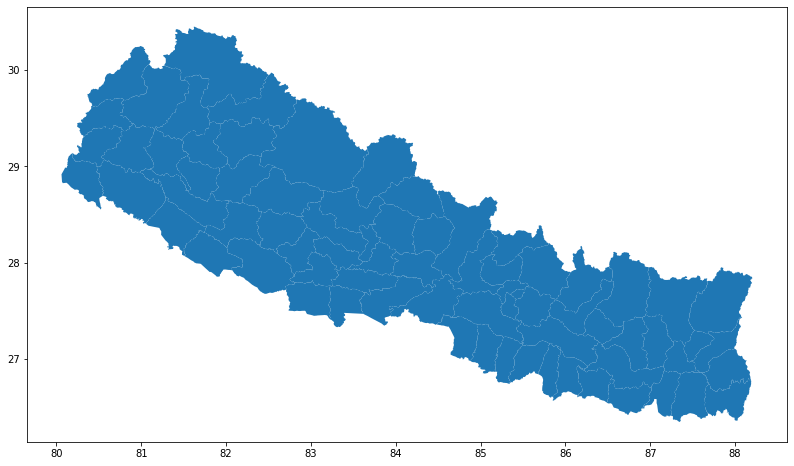

In [27]:
# Visualización del shapefile
nep_districts.plot(
    # Cambiar el tamaño del gráfico
    figsize = (16,8)
)

## 2.8 Procesar los shapefiles

De las variables del shapefile, se requieren principalmente de `NAME_3` y `geometry`. El primero para relacionarlo con la variable que guarda los valores de población por distrito; el segundo, tiene los polígonos de los distrito de Nepal.

In [28]:
nep_districts = nep_districts[['NAME_3', 'geometry']]

In [29]:
nep_districts

,NAME_3,geometry
0,Bhaktapur,"POLYGON ((85.52173 27.71822, 85.52359 27.71375..."
1,Dhading,"POLYGON ((85.11038 28.34680, 85.11222 28.34392..."
2,Kathmandu,"POLYGON ((85.45375 27.81118, 85.45537 27.80906..."
3,Kavrepalanchok,"POLYGON ((85.55230 27.75662, 85.55180 27.75426..."
4,Lalitpur,"POLYGON ((85.34588 27.67149, 85.35433 27.66776..."
...,...,...
70,Gulmi,"POLYGON ((83.19185 28.26453, 83.20638 28.25558..."
71,Kapilbastu,"POLYGON ((83.03501 27.79316, 83.03489 27.78359..."
72,Nawalparasi,"POLYGON ((84.10302 27.86387, 84.09755 27.85927..."
73,Palpa,"POLYGON ((83.37988 27.95869, 83.37875 27.95583..."


Renombras las variables.

In [30]:
# Renombras las variables
nep_districts.rename(
    columns = {
        'NAME_3' : 'District'
    },
    inplace = True
)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [31]:
nep_districts

,District,geometry
0,Bhaktapur,"POLYGON ((85.52173 27.71822, 85.52359 27.71375..."
1,Dhading,"POLYGON ((85.11038 28.34680, 85.11222 28.34392..."
2,Kathmandu,"POLYGON ((85.45375 27.81118, 85.45537 27.80906..."
3,Kavrepalanchok,"POLYGON ((85.55230 27.75662, 85.55180 27.75426..."
4,Lalitpur,"POLYGON ((85.34588 27.67149, 85.35433 27.66776..."
...,...,...
70,Gulmi,"POLYGON ((83.19185 28.26453, 83.20638 28.25558..."
71,Kapilbastu,"POLYGON ((83.03501 27.79316, 83.03489 27.78359..."
72,Nawalparasi,"POLYGON ((84.10302 27.86387, 84.09755 27.85927..."
73,Palpa,"POLYGON ((83.37988 27.95869, 83.37875 27.95583..."


### 2.8.1 Reproyectar

Antes de reproyectar, se debe conocer en que Sistema de Referencia de Coordenadas (CRS) se encuentra la data.

In [32]:
# Ver el CRS
nep_districts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Se debe buscar un CRS adecuado para la zona de Nepal. Uno de ellos es EPSG: 32645. https://epsg.io/32645

In [33]:
# Reproyectar con EPSG: 32645
nep_districts.to_crs(epsg=32645, inplace = True)

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [34]:
# Ver el CRS
nep_districts.crs

<Projected CRS: EPSG:32645>
Name: WGS 84 / UTM zone 45N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 84°E to 90°E - by country
- bounds: (84.0, 0.0, 90.0, 84.0)
Coordinate Operation:
- name: UTM zone 45N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 2.8.2 Arreglar los valores

Antes de unir la variable `population_data` con `nep_districts` se debe verificar que los nombres de los distritos coincidan.

In [35]:
for index, row in nep_districts['District'].iteritems():
    if row in population_data['District'].tolist():
        pass
    else:
        print('El distrito ', row , ' no está en variable District de population_data')

El distrito  Sindhupalchok  no está en variable District de population_data
El distrito  Chitawan  no está en variable District de population_data
El distrito  Terhathum  no está en variable District de population_data
El distrito  Dang  no está en variable District de population_data
El distrito  Tanahu  no está en variable District de population_data
El distrito  Kapilbastu  no está en variable District de population_data


Arreglar los nombres de los distritos.

In [36]:
population_data.replace('Sindhupalchowk', 'Sindhupalchok', inplace = True)
population_data.replace('Chitwan', 'Chitawan', inplace = True)
population_data.replace('Tehrathum', 'Terhathum', inplace = True)
population_data.replace('Dang Deukhuri', 'Dang', inplace = True)
population_data.replace('Tanahun', 'Tanahu', inplace = True)
population_data.replace('Kapilvastu', 'Kapilbastu', inplace = True)

Crear una nueva columna que almacene las áres de los distritos de Nepal.

In [37]:
# Área en km^2
nep_districts['area_km2'] = nep_districts.area/1000000

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [38]:
nep_districts

,District,geometry,area_km2
0,Bhaktapur,"POLYGON ((354267.048 3066863.329, 354444.648 3...",122.781583
1,Dhading,"POLYGON ((314787.633 3137070.191, 314962.895 3...",1885.579794
2,Kathmandu,"POLYGON ((347694.158 3077244.689, 347850.554 3...",414.119566
3,Kavrepalanchok,"POLYGON ((357331.250 3071081.974, 357279.293 3...",1391.380564
4,Lalitpur,"POLYGON ((336859.084 3061906.723, 337687.434 3...",395.434344
...,...,...,...
70,Gulmi,"POLYGON ((126338.517 3132391.766, 127734.618 3...",1110.909076
71,Kapilbastu,"POLYGON ((109232.958 3080600.818, 109186.616 3...",1655.534564
72,Nawalparasi,"POLYGON ((214735.504 3085494.995, 214184.508 3...",2155.336845
73,Palpa,"POLYGON ((143790.806 3097906.565, 143670.968 3...",1465.395220


Hacer una unión de `nep_districts` con `population_data` mediante la variable `District`.

In [39]:
# Do an attributes join 
nep_districts = nep_districts.merge(population_data, on = 'District')

In [40]:
nep_districts

,District,geometry,area_km2,Population
0,Bhaktapur,"POLYGON ((354267.048 3066863.329, 354444.648 3...",122.781583,304651
1,Dhading,"POLYGON ((314787.633 3137070.191, 314962.895 3...",1885.579794,336067
2,Kathmandu,"POLYGON ((347694.158 3077244.689, 347850.554 3...",414.119566,1744240
3,Kavrepalanchok,"POLYGON ((357331.250 3071081.974, 357279.293 3...",1391.380564,381937
4,Lalitpur,"POLYGON ((336859.084 3061906.723, 337687.434 3...",395.434344,468132
...,...,...,...,...
72,Kapilbastu,"POLYGON ((109232.958 3080600.818, 109186.616 3...",1655.534564,571936
73,Nawalparasi,"POLYGON ((214735.504 3085494.995, 214184.508 3...",2155.336845,311604
74,Nawalparasi,"POLYGON ((214735.504 3085494.995, 214184.508 3...",2155.336845,331904
75,Palpa,"POLYGON ((143790.806 3097906.565, 143670.968 3...",1465.395220,261180


Calcular la densidad población de cada distrito.

In [41]:
# Densidad de población: población/kilómtero cuadrado
nep_districts['pop_den'] = nep_districts['Population']/nep_districts['area_km2']

In [43]:
nep_districts

,District,geometry,area_km2,Population,pop_den
0,Bhaktapur,"POLYGON ((354267.048 3066863.329, 354444.648 3...",122.781583,304651,2481.243466
1,Dhading,"POLYGON ((314787.633 3137070.191, 314962.895 3...",1885.579794,336067,178.230060
2,Kathmandu,"POLYGON ((347694.158 3077244.689, 347850.554 3...",414.119566,1744240,4211.923662
3,Kavrepalanchok,"POLYGON ((357331.250 3071081.974, 357279.293 3...",1391.380564,381937,274.502181
4,Lalitpur,"POLYGON ((336859.084 3061906.723, 337687.434 3...",395.434344,468132,1183.842544
...,...,...,...,...,...
72,Kapilbastu,"POLYGON ((109232.958 3080600.818, 109186.616 3...",1655.534564,571936,345.469078
73,Nawalparasi,"POLYGON ((214735.504 3085494.995, 214184.508 3...",2155.336845,311604,144.573226
74,Nawalparasi,"POLYGON ((214735.504 3085494.995, 214184.508 3...",2155.336845,331904,153.991707
75,Palpa,"POLYGON ((143790.806 3097906.565, 143670.968 3...",1465.395220,261180,178.231781


## 2.9 Graficar un mapa

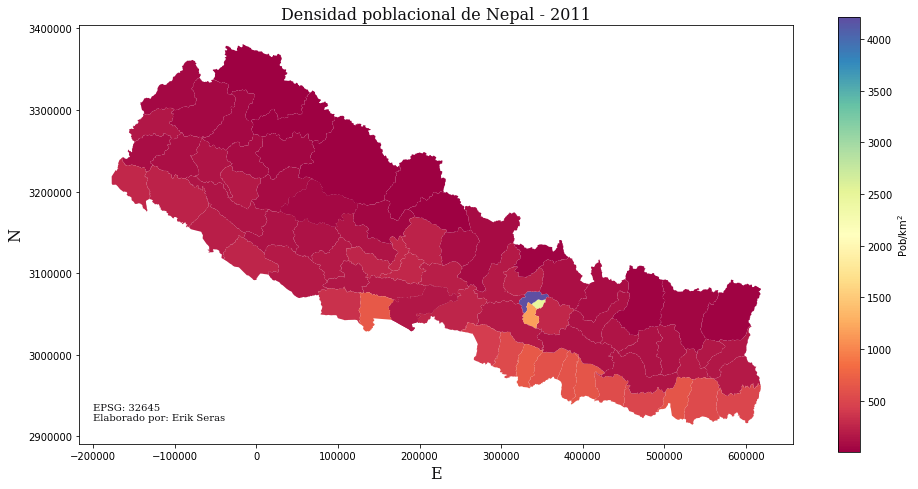

In [87]:
# Establecer la letra a mostrar
font = {
    'family': 'serif',
    'color':  '#101012',
    'weight': 'normal',
    'size': 16
}

# Crear figura y sus ejes
fig, ax = plt.subplots(figsize = (16,8))

# Establecer características de los ejes
ax.ticklabel_format(
    # Evitar la notación científica en los ejes
    useOffset=False,
    style='plain'
)

# Gráficar los valores de densidad poblacional
nep_districts.plot(
    column = 'pop_den', cmap = 'Spectral', legend = True,
    ax=ax,
    legend_kwds= {
        'label': "Pob/km$^{2}$",'orientation': "vertical"
    }
)

# Texto en el título
plt.title(
    label = 'Densidad poblacional de Nepal - 2011',
    fontdict = font
)
# Texto en el eje y
plt.ylabel(
    ylabel = 'N',
    fontdict = font
)
# Texto en el eje x
plt.xlabel(
    xlabel = 'E',
    fontdict = font
)

# Añadir texto al gráfico
plt.text(
    x = -200000, y = 2920000, s = 'EPSG: 32645\nElaborado por: Erik Seras',
    fontdict= {
        'family': 'serif',
        'color':  '#101012',
        'weight': 'normal',
        'size': 10
})


# Guardar el gráfico generado
plt.savefig(
    fname = 'den_pob_nepal_2011.png', dpi=600,
    bbox_inches='tight'
)

# Mostrar el gráfico
plt.show()